***Modelo para prever quanto tempo o paciente ficará no hospital***

Nesse estudo Iremos comparar a viablidade dos modelos por Random Forest, KNRegressor e LinearRegression


In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, make_scorer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore', category=Warning)
from sklearn.pipeline import Pipeline
from sklearn import set_config
from sklearn.metrics import recall_score,make_scorer,accuracy_score,f1_score
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import KFold,cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from joblib import dump, load
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [2]:
df = pd.read_csv(r"C:\Users\Pedro\Desktop\Portifolio\Medical_Data.csv")

In [3]:
pd.set_option('display.max_columns', None)

In [4]:
df.head()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_Caucasian,race_AfricanAmerican,gender_Female,age_[70-80),age_[60-70),age_[50-60),age_[80-90),age_[40-50),payer_code_?,payer_code_MC,payer_code_HM,payer_code_SP,payer_code_BC,medical_specialty_?,medical_specialty_InternalMedicine,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_Cardiology,diag_1_428,diag_1_414,diag_1_786,diag_2_276,diag_2_428,diag_2_250,diag_2_427,diag_3_250,diag_3_401,diag_3_276,diag_3_428,max_glu_serum_None,A1Cresult_None,metformin_No,repaglinide_No,nateglinide_No,chlorpropamide_No,glimepiride_No,acetohexamide_No,glipizide_No,glyburide_No,tolbutamide_No,pioglitazone_No,rosiglitazone_No,acarbose_No,miglitol_No,troglitazone_No,tolazamide_No,examide_No,citoglipton_No,insulin_No,glyburide-metformin_No,glipizide-metformin_No,glimepiride-pioglitazone_No,metformin-rosiglitazone_No,metformin-pioglitazone_No,change_No,diabetesMed_Yes,readmitted
0,14,41,0,11,0,0,0,6,True,False,False,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,0
1,2,30,0,12,0,0,1,9,True,False,True,False,False,True,False,False,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,False,True,True,True,True,True,False,True,1
2,5,66,0,22,1,0,2,9,True,False,True,False,False,False,True,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1
3,3,63,0,8,0,0,0,8,True,False,True,False,False,True,False,False,True,False,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,True,True,True,True,True,True,True,True,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,1
4,5,40,0,6,0,0,1,9,True,False,True,False,False,False,True,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,False,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,True,False,0


In [5]:
df.shape

(25000, 65)

In [6]:
for i in range(0,65):
    for k in range(0,25000):
        if df[df.columns[i]][k] == True :
            df[df.columns[i]][k] = 1
        if df[df.columns[i]][k] == False :
            df[df.columns[i]][k] = 0

In [7]:
df = df.infer_objects()


In [8]:
X = df.drop(columns='time_in_hospital',axis = 1)
y = df['time_in_hospital']

A fim de otimizar nosso modelo, usamos SelectKBest, a fim de selecionar as colunas mais relevantes para a nossa análise. 

In [9]:
select = SelectKBest(score_func=chi2, k=40)
z = select.fit_transform(X,y)


In [10]:
filtered_columns = select.get_support()

In [11]:
X_limpo = X[X.columns[filtered_columns]]


In [12]:
X_limpo

,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,number_diagnoses,race_AfricanAmerican,gender_Female,age_[70-80),age_[60-70),age_[50-60),age_[80-90),age_[40-50),payer_code_?,payer_code_MC,payer_code_HM,payer_code_SP,payer_code_BC,medical_specialty_?,medical_specialty_InternalMedicine,medical_specialty_Emergency/Trauma,medical_specialty_Family/GeneralPractice,medical_specialty_Cardiology,diag_1_428,diag_1_414,diag_1_786,diag_2_276,diag_2_428,diag_2_250,diag_2_427,diag_3_250,diag_3_401,diag_3_276,diag_3_428,A1Cresult_None,insulin_No,change_No,diabetesMed_Yes,readmitted
0,41,0,11,0,0,0,6,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,1,0
1,30,0,12,0,0,1,9,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
2,66,0,22,1,0,2,9,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
3,63,0,8,0,0,0,8,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1
4,40,0,6,0,0,1,9,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24995,85,0,12,0,0,0,9,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0
24996,35,2,15,0,0,0,9,1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1
24997,10,1,23,1,0,0,4,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,1
24998,69,3,41,1,0,0,9,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,1


Separando os dados de treino e teste;

In [13]:
X_train , X_test , y_train , y_test = train_test_split(X_limpo, y, test_size=0.20, stratify=y)

Utilizando Gridsearch com Random Forest

In [15]:
lista_etapas = [("std_scaler", StandardScaler()), 
                ("rf", RandomForestClassifier(n_estimators=3, \
                                                   max_depth=5, \
                                                   random_state=42, \
                                                   n_jobs=-1))]

pipe_rf = Pipeline(lista_etapas)

metrica = make_scorer(r2_score)

splitter = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

param_grid = {"rf__n_estimators" : range(150,200,10),
              "rf__max_depth" : range(3, 8),
              "rf__max_features" : range(2, 5)}

In [16]:
grid_rf = GridSearchCV(estimator=pipe_rf, 
                        param_grid=param_grid,
                        scoring=metrica,
                        cv=splitter,
                        verbose=10)

In [17]:
grid_rf.fit(X_train,y_train)


Fitting 10 folds for each of 75 candidates, totalling 750 fits
[CV 1/10; 1/75] START rf__max_depth=3, rf__max_features=2, rf__n_estimators=150.
[CV 1/10; 1/75] END rf__max_depth=3, rf__max_features=2, rf__n_estimators=150;, score=-0.244 total time=   5.3s
[CV 2/10; 1/75] START rf__max_depth=3, rf__max_features=2, rf__n_estimators=150.
[CV 2/10; 1/75] END rf__max_depth=3, rf__max_features=2, rf__n_estimators=150;, score=-0.258 total time=   0.6s
[CV 3/10; 1/75] START rf__max_depth=3, rf__max_features=2, rf__n_estimators=150.
[CV 3/10; 1/75] END rf__max_depth=3, rf__max_features=2, rf__n_estimators=150;, score=-0.265 total time=   0.6s
[CV 4/10; 1/75] START rf__max_depth=3, rf__max_features=2, rf__n_estimators=150.
[CV 4/10; 1/75] END rf__max_depth=3, rf__max_features=2, rf__n_estimators=150;, score=-0.262 total time=   0.6s
[CV 5/10; 1/75] START rf__max_depth=3, rf__max_features=2, rf__n_estimators=150.
[CV 5/10; 1/75] END rf__max_depth=3, rf__max_features=2, rf__n_estimators=150;, scor

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('rf',
                                        RandomForestClassifier(max_depth=5,
                                                               n_estimators=3,
                                                               n_jobs=-1,
                                                               random_state=42))]),
             param_grid={'rf__max_depth': range(3, 8),
                         'rf__max_features': range(2, 5),
                         'rf__n_estimators': range(150, 200, 10)},
             scoring=make_scorer(r2_score), verbose=10)

In [18]:
y_pred_1 = grid_rf.predict(X_test)

In [19]:
r2_score(y_test, y_pred_1)

-0.13594748731104112

In [20]:
mean_absolute_error(y_test, y_pred_1)

2.1486

In [21]:
mean_squared_error(y_test, y_pred_1)

10.1582

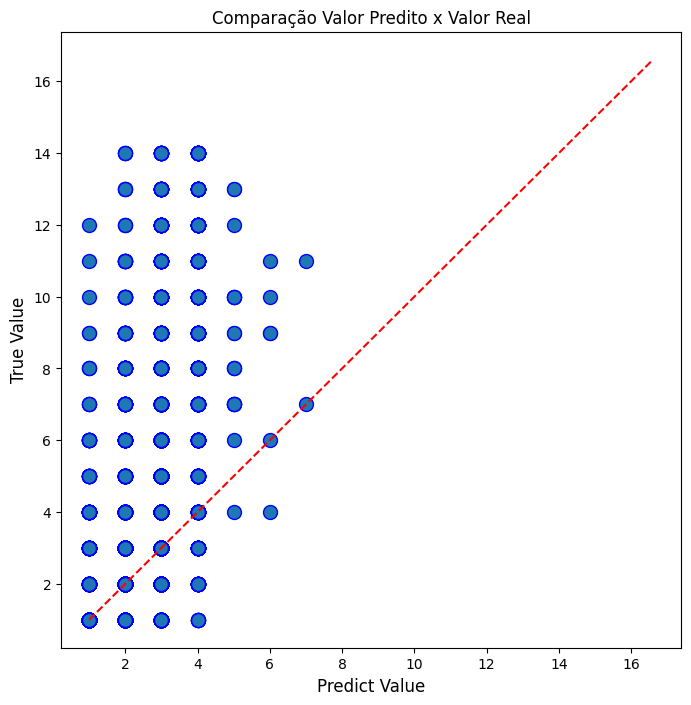

In [43]:
## define tamanho da figura
fig = plt.figure(figsize=(8,8))

# Configurações do plot
l = plt.plot(y_pred_1, y_test, 'bo') # Define os eixos x e y. O argumento 'bo' indica que queremos que os elementos
                                    # apareçam como circulos azuis
plt.setp(l, markersize=10)          # Aqui definimos o tamanho dos circulos
plt.setp(l, markerfacecolor='C0')   # Aqui definimos a cor do contorno

## Titulo e eixos
plt.title('Comparação Valor Predito x Valor Real', fontsize=12)
plt.ylabel("True Value", fontsize=12)
plt.xlabel("Predict Value", fontsize=12)

## Aqui definimos a equação da reta de aproximação e adicionamos ela no plot
xl = np.arange(min(y_test), 1.2*max(y_test),(max(y_test)-min(y_test))/10)
yl = xl
plt.plot(xl, yl, 'r--')

## Exibição
plt.show()

**Como observado acima o MAE e o MSE distantes um do outro e o r2_score negativo indicam que o modelo não ficou viável, vamos explorar outras formas;**

In [14]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression

In [30]:
lista_etapas1 = [("std_scaler", StandardScaler()), 
                ("knr", KNeighborsRegressor())]

pipe_knr = Pipeline(lista_etapas1)


splitter1 = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

metrica1 = make_scorer(r2_score)

param_grid1 = {"knr__weights" : ["uniform", "distance"],
              "knr__metric" : ["manhattan", "euclidean"],
              "knr__n_neighbors" : range(2, 21)}

In [31]:
grid_knr = GridSearchCV(estimator=pipe_knr, 
                        param_grid=param_grid1,
                        scoring=metrica1,
                        cv=splitter1,
                        verbose=10)

In [32]:
grid_knr.fit(X_train,y_train)

Fitting 10 folds for each of 76 candidates, totalling 760 fits
[CV 1/10; 1/76] START knr__metric=manhattan, knr__n_neighbors=2, knr__weights=uniform
[CV 1/10; 1/76] END knr__metric=manhattan, knr__n_neighbors=2, knr__weights=uniform;, score=-0.056 total time=   0.5s
[CV 2/10; 1/76] START knr__metric=manhattan, knr__n_neighbors=2, knr__weights=uniform
[CV 2/10; 1/76] END knr__metric=manhattan, knr__n_neighbors=2, knr__weights=uniform;, score=-0.026 total time=   0.4s
[CV 3/10; 1/76] START knr__metric=manhattan, knr__n_neighbors=2, knr__weights=uniform
[CV 3/10; 1/76] END knr__metric=manhattan, knr__n_neighbors=2, knr__weights=uniform;, score=-0.109 total time=   0.4s
[CV 4/10; 1/76] START knr__metric=manhattan, knr__n_neighbors=2, knr__weights=uniform
[CV 4/10; 1/76] END knr__metric=manhattan, knr__n_neighbors=2, knr__weights=uniform;, score=-0.055 total time=   0.4s
[CV 5/10; 1/76] START knr__metric=manhattan, knr__n_neighbors=2, knr__weights=uniform
[CV 5/10; 1/76] END knr__metric=man

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('std_scaler', StandardScaler()),
                                       ('knr', KNeighborsRegressor())]),
             param_grid={'knr__metric': ['manhattan', 'euclidean'],
                         'knr__n_neighbors': range(2, 21),
                         'knr__weights': ['uniform', 'distance']},
             scoring=make_scorer(r2_score), verbose=10)

In [33]:
y_pred_2 = grid_knr.predict(X_test)

In [34]:
r2_score(y_test, y_pred_2)

0.233723538536455

In [35]:
mean_absolute_error(y_test, y_pred_2)

2.008312268046999

In [36]:
mean_squared_error(y_test, y_pred_2)

6.852420237545363

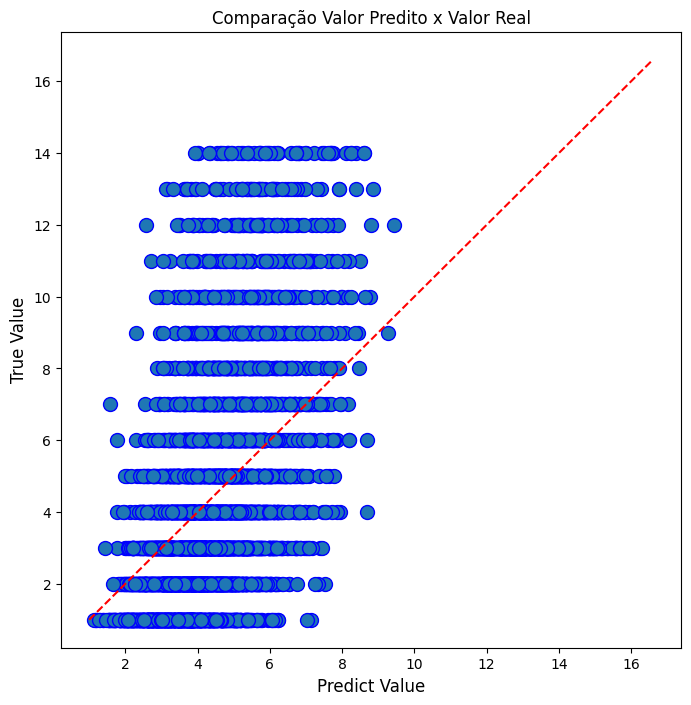

In [44]:
## define tamanho da figura
fig = plt.figure(figsize=(8,8))

# Configurações do plot
l = plt.plot(y_pred_2, y_test, 'bo') # Define os eixos x e y. O argumento 'bo' indica que queremos que os elementos
                                    # apareçam como circulos azuis
plt.setp(l, markersize=10)          # Aqui definimos o tamanho dos circulos
plt.setp(l, markerfacecolor='C0')   # Aqui definimos a cor do contorno

## Titulo e eixos
plt.title('Comparação Valor Predito x Valor Real', fontsize=12)
plt.ylabel("True Value", fontsize=12)
plt.xlabel("Predict Value", fontsize=12)

## Aqui definimos a equação da reta de aproximação e adicionamos ela no plot
xl = np.arange(min(y_test), 1.2*max(y_test),(max(y_test)-min(y_test))/10)
yl = xl
plt.plot(xl, yl, 'r--')

## Exibição
plt.show()

**Observamos acima uma melhora no r2 score e uma aproximação na MSQ e MAE, seguiremos abaixo para regressão linear simples**

In [37]:
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [38]:
y_pred_3 = model.predict(X_test)

In [39]:
r2_score(y_test, y_pred_3)

0.32803866093390954

In [40]:
mean_absolute_error(y_test, y_pred_3)

1.8651619109973625

In [41]:
mean_squared_error(y_test, y_pred_3)

6.0090081194326475

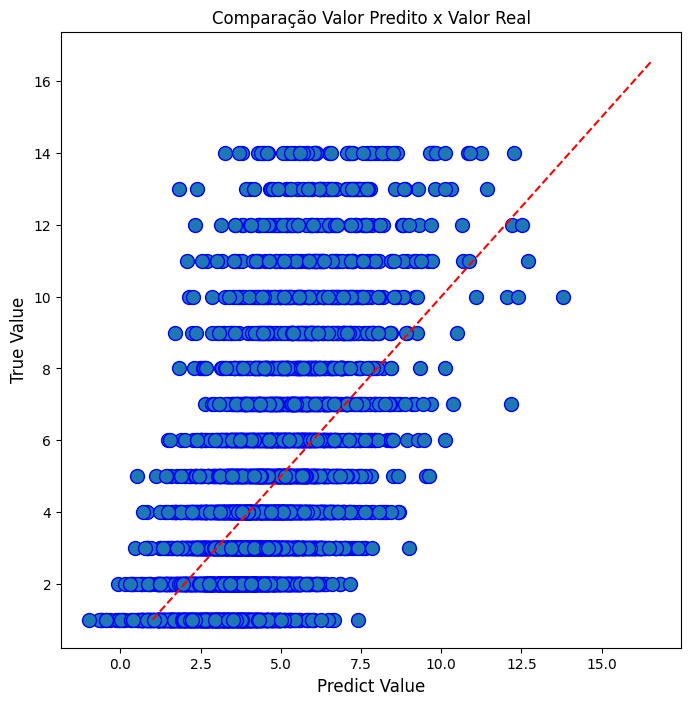

In [45]:
## define tamanho da figura
fig = plt.figure(figsize=(8,8))

# Configurações do plot
l = plt.plot(y_pred_3, y_test, 'bo') # Define os eixos x e y. O argumento 'bo' indica que queremos que os elementos
                                    # apareçam como circulos azuis
plt.setp(l, markersize=10)          # Aqui definimos o tamanho dos circulos
plt.setp(l, markerfacecolor='C0')   # Aqui definimos a cor do contorno

## Titulo e eixos
plt.title('Comparação Valor Predito x Valor Real', fontsize=12)
plt.ylabel("True Value", fontsize=12)
plt.xlabel("Predict Value", fontsize=12)

## Aqui definimos a equação da reta de aproximação e adicionamos ela no plot
xl = np.arange(min(y_test), 1.2*max(y_test),(max(y_test)-min(y_test))/10)
yl = xl
plt.plot(xl, yl, 'r--')

## Exibição
plt.show()

Após obeservar os dados acima vemos que a Regressão Linear simples perfoma melhor que os demais modelos, ainda assimn não indicaria a aplicação de nenhum modelo devido ao baixo r2 score e da má distribuiçã do modelo nos graficos do Valor Predito x Valor Real